In [483]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [484]:
def plot_2d_function(f, x1_range: list, x2_range: list, N=1000):
    x1 = np.linspace(x1_range[0], x1_range[1], N)
    x2 = np.linspace(x2_range[0], x2_range[1], N)
    x1_mesh, x2_mesh = np.meshgrid(x1, x2)
    f_mesh = f([x1_mesh, x2_mesh])

    # Create a contour plot
    plt.style.use("dark_background")
    plt.figure(figsize=(11, 6))
    plt.contourf(x1_mesh, x2_mesh, f_mesh, levels=25, cmap="gist_rainbow")
    plt.colorbar()
    # Add some text to the plot
    plt.xlabel('x1')
    plt.ylabel('x2')
    
def add_opt_path(x_iters, color, color2, label: str):
    plt.scatter(x_iters[:, 0], x_iters[:, 1], color=color, linewidth=0.1)
    plt.plot(x_iters[:, 0], x_iters[:, 1], color=color2, linewidth=1, label=label)  

### Line Search Method
---

In [485]:
def line_search(f, x, p, grad, alpha=1, r=0.8, c=0.9):
  # backtracking algortihm from page 37

    while f(x + alpha * p) > f(x) + (c * alpha * grad(x).T @ p):
        alpha = r * alpha

    return alpha

### Gradient Descent
---

In [486]:
def gradient_descent(f, grad, x_0, tol= 0.1, alpha=0.1, n_iters=99):
    x = x_0
    x_iters = [x.reshape(-1,1)]
    i = 0
    while np.linalg.norm(grad(x)) > tol and i < n_iters:
        i += 1
        p = -1 * grad(x)
        alpha = line_search(f, x, p, grad)
        x_new = x - alpha * grad(x)
        x_iters.append(x_new.reshape(-1,1))
        x = x_new
#     print("Converged at:",i)
    return np.array(x_iters)

### Newton Method
---

In [487]:
def newton_method(x_start:list, f, grad, hess, tol=1e-4, n_iter = 100):
    x = x_start
    i = 0
    x_iters = [x.reshape(-1,1)]
    while np.linalg.norm(grad(x)) > tol and i < n_iter:
        i += 1 
        pk = -(hess(x) @ grad(x))
        ak = line_search(f, x, pk, grad)
        x_next = x + ak * pk
        x = x_next
        x_iters.append(x.reshape(-1,1))
#         if i % 10 == 0: print(f"[{i}] loss:", np.linalg.norm(grad(x)))
#     print("Converged at iteration:", i)
    return np.array(x_iters)

### Conjugate Gradient Method: Fletcher-Reeves
---

In [488]:
def grad_approx(f, x, args=None, h=1e-3):
    """central difference approximation of gradient
    param: f - function, takes as argument only x, returns scalar, can be seen as f(x)=f(x1,x2,x3,...xn)
    param: x - array of arguments can be seen as [x1,x2,x3...xn] or [x,y,z...]
    param: h - difference scalar"""
    grad = np.zeros(x.shape)
    for i, arg in enumerate(x):
        plus_h = np.copy(x)
        plus_h[i] = arg+h
        
        minus_h = np.copy(x)
        minus_h[i] = arg-h
        if not args==None:
            f_plus_h = f(plus_h,**args)
            f_minus_h = f(minus_h,**args)
        else:
            f_plus_h = f(plus_h)
            f_minus_h = f(minus_h)
        
        grad[i] = (f_plus_h-f_minus_h)/(2*h)
    return grad

def hess_approx(f, x, args=None, h=1e-2, noise=False):
    hess = np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        one_hot = np.zeros(x.shape[0])
        one_hot[i]=1
        one_hot = one_hot*h
        
        plus_oh = x+one_hot
        minus_oh = x-one_hot
        if not args==None:
            f_plus  = grad_approx(f,plus_oh,args)
            f_minus = grad_approx(f,minus_oh,args)
        else:
            f_plus  = grad_approx(f,plus_oh)
            f_minus = grad_approx(f,minus_oh)
            
        hess[:,i]= (f_plus-f_minus)/(2*h)
    if noise:
        noise = np.random.normal(0,1,hess.shape)#normal distributed, mean 0, std 1
        hess = hess + noise
    return hess

def line_search2(f,x,pk,α=1,p=0.8,c1=1e-4,c2=0.9):#c1 c2 are chosen by reccomendations from book
    while (f(x+α*pk)>f(x)+c1*α*grad_approx(f,x)@pk) :#3.6.a, Wolfe cond
        α = α*p
    return α

def fletcher_reeves(f,x,x_true,tol=1e-4,stop=4e+4,entertain=False):
    """x_true is an optimal x which is used for plots
    plot is a callable plorring function of your choice"""
    i, αk = 0, 1
    
    grad = grad_approx(f,x)#approximate gradient with the central difference coefficient
    pk = -grad.T
    x_iters = [x.reshape(-1,1)]
    while not np.allclose(np.zeros(grad.shape),grad,atol=tol) and i<=stop:
        #direction and alpha
        αk = line_search2(f,x,pk)
        #k+1
        x_next = x+αk*pk
        grad_next = grad_approx(f,x_next)    
        βk = (grad_next@grad_next.T)/(grad@grad.T)
        pk_next = -grad_next +βk*pk
        
        #reassign
        x, grad, pk = x_next, grad_next, pk_next
        i+=1
        x_iters.append(x.reshape(-1,1))
    return np.array(x_iters)

### Quasi Newton: Symmetric Rank One 
---

In [489]:
from scipy.optimize import minimize

def alpha_search(f, x_curr, p):
    fun = lambda alpha: f(x_curr - alpha * p)
    res = minimize(fun, [0], method='Nelder-Mead')
    return res.x[0]

def sr1(f, grad, x_0, linesearch, alpha, n_iters):
    B_curr = np.identity(2)
    H_curr = np.linalg.inv(B_curr)
    x_curr = x_0
    x_new  = x_curr - alpha * grad(x_curr)
    s_curr = x_new - x_curr
    y_curr = grad(x_new) - grad(x_curr)
    
    x_iters_sr1 = [x_0]
    
    for i in range(1, n_iters):
        g = grad(x_curr)
        p = H_curr.dot(g)
        
        if linesearch: alpha = alpha_search(f, x_curr, p)
        x_new = x_curr - alpha * p
        
        s_new = x_new - x_curr
        y_new = grad(x_new) - grad(x_curr)
        s_curr = s_new
        y_curr = y_new
        
        b = y_curr - B_curr.dot(s_curr)
        B_new = B_curr + b.dot(b.T) / (b.T.dot(s_curr) + 10**-8)
        
        a = s_curr - H_curr.dot(y_curr)
        H_new = H_curr + a.dot(a.T) / (a.T.dot(y_curr) + 10**-8)
        
        r = 10**-8
        if s_curr.T.dot(b) > r * np.sqrt(s_curr.T.dot(s_curr) * b.T.dot(b)):
            H_curr = H_new
            B_curr = B_new
        
        x_iters_sr1.append(x_new)
        x_curr = x_new
        
    return np.array(x_iters_sr1)

### Broyden-Fletcher-Goldfarb-Shanno Algorithm
---

In [490]:
def bfgs(f, grad, x_0, line_search, alpha, n_iters):
    H_curr = np.identity(2)
    x_curr = x_0
    x_new  = x_curr - alpha * grad(x_curr)
    s_curr = x_new - x_curr
    y_curr = grad(x_new) - grad(x_curr)
    
    x_iters_bfgs = [x_0]
    
    for i in range(1, n_iters):
        g = grad(x_curr)
        p = H_curr.dot(g)
        
        if line_search: alpha = alpha_search(f, x_curr, p)
        x_new = x_curr - alpha * p
        
        # s u y
        s_new = x_new - x_curr
        y_new = grad(x_new) - grad(x_curr)
        s_curr = s_new
        y_curr = y_new
        
        # H
        pho = 1. / (y_curr.T.dot(s_curr) + 10**-8)
        a = np.identity(2) - pho * s_curr.dot(y_curr.T)
        b = np.identity(2) - pho * y_curr.dot(s_curr.T)
        H_new = a.dot( H_curr.dot(b) ) + pho * s_curr.dot(s_curr.T)
        H_curr = H_new
        
        x_iters_bfgs.append(x_new)
        x_curr = x_new
        
    return np.array(x_iters_bfgs)

### Trust Region Method
---

In [491]:
import numpy as np
import numpy.linalg as ln
import scipy as sp
from math import sqrt

def dogleg_method(Hk, gk, Bk, trust_radius):
    pB = -np.dot(Hk, gk)
    norm_pB = sqrt(np.dot(pB, pB))

    if norm_pB <= trust_radius:
        return pB

    pU = - (np.dot(gk, gk) / np.dot(gk, np.dot(Bk, gk))) * gk
    dot_pU = np.dot(pU, pU)
    norm_pU = sqrt(dot_pU)

    if norm_pU >= trust_radius:
        return trust_radius * pU / norm_pU

    pB_pU = pB - pU
    dot_pB_pU = np.dot(pB_pU, pB_pU)
    dot_pU_pB_pU = np.dot(pU, pB_pU)
    fact = dot_pU_pB_pU ** 2 - dot_pB_pU * (dot_pU - trust_radius ** 2)
    tau = (-dot_pU_pB_pU + sqrt(fact)) / dot_pB_pU

    return pU + tau * pB_pU


def trust_region_dogleg(func, jac, hess, x0, initial_trust_radius=1.0,
                        max_trust_radius=100.0, eta=0.15, gtol=1e-4,
                        maxiter=100):
    xk = x0
    trust_radius = initial_trust_radius
    k = 0
    x_iters = [xk.reshape(-1,1)]
    while True:
        gk = jac(xk)
        Bk = hess(xk)
        Hk = np.linalg.inv(Bk)

        pk = dogleg_method(Hk, gk, Bk, trust_radius)

        act_red = func(xk) - func(xk + pk)

        pred_red = -(np.dot(gk, pk) + 0.5 * np.dot(pk, np.dot(Bk, pk)))

        rhok = act_red / pred_red
        if pred_red == 0.0:
            rhok = 1e99
        else:
            rhok = act_red / pred_red

        norm_pk = sqrt(np.dot(pk, pk))

        if rhok < 0.25:
            trust_radius = 0.25 * norm_pk
        else:
            if rhok > 0.75 and norm_pk == trust_radius:
                trust_radius = min(2.0 * trust_radius, max_trust_radius)
            else:
                trust_radius = trust_radius

        if rhok > eta:
            xk = xk + pk
        else:
            xk = xk
            
        x_iters.append(xk.reshape(-1,1))
        
        if ln.norm(gk) < gtol:
            break

        if k >= maxiter:
            break
        k = k + 1
    return np.array(x_iters)


# 6) 2 Variables Order 4 Polynomial 
---

$$
f(x) = x_1^4 + x_2^4 + 2x_1 x_2 + 0.5 
$$

+ function has 2 local minimas

In [492]:
# define objective function
def f(x):
    x1 = x[0]
    x2 = x[1]
    obj = x1**4 - 2.0 * x1 * x2 + 4 * x2**4 + 0.5
    return obj

# define objective gradient
def grad(x):
    x1 = x[0]
    x2 = x[1]
    grad = np.array([4.0 * x1 ** 3 - 2.0 * x2, -2.0 * x1 + 16.0 * x2 ** 3])
    return grad

# Exact 2nd derivatives (hessian)
def hess(x):
    x1 = x[0]
    x2 = x[1]
    H = np.array([[12.0 * x1 ** 2, -2.0], [-2.0, 48.0 * x2 ** 2]])
    return H

In [493]:
x_start = np.array([-1.4, -0.5])

In [494]:
x_gr = gradient_descent(f, grad, x_start.reshape(-1,1))

In [495]:
x_n = newton_method(x_start, f, grad, hess)

In [496]:
x_fr = fletcher_reeves(f=f, x=x_start, x_true=None, tol=1e-4, stop=1e+2)

In [497]:
x_sr1 = sr1(f, grad, x_start, linesearch=True, alpha=0.1, n_iters=100)

In [498]:
x_bfgs = bfgs(f, grad, x_start, line_search=True, alpha=0.1, n_iters=100)

In [499]:
x_trust = trust_region_dogleg(f, grad, hess, x_start)

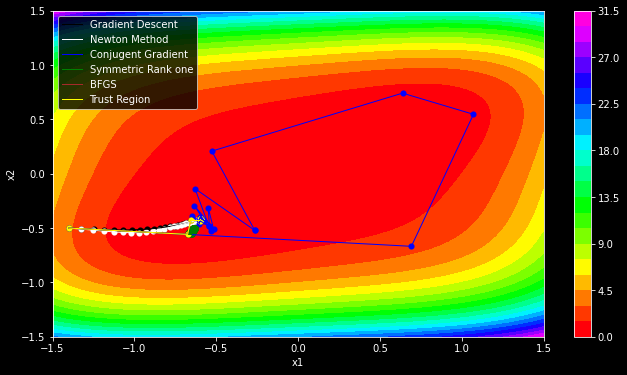

In [500]:
r = 1.5
plot_2d_function(f, x1_range=[-r, r], x2_range=[-r, r])
add_opt_path(x_gr, color="black",color2="black", label="Gradient Descent")
add_opt_path(x_n, color="white",color2="white", label="Newton Method")
add_opt_path(x_fr, color="blue",color2="blue", label="Conjugent Gradient")
add_opt_path(x_sr1, color="green",color2="green", label="Symmetric Rank one")
add_opt_path(x_bfgs, color="brown",color2="brown", label="BFGS")
add_opt_path(x_bfgs, color="yellow",color2="yellow", label="Trust Region")
plt.legend()

In [501]:
minima_solution_checked_per_geogebra = [-0.59,-0.42]
data={"minima":minima_solution_checked_per_geogebra,"gradient descent":x_gr[-1].flatten(),"newton method":x_n[-1].flatten(),"conjugent gradient":x_fr[-1].flatten(),
      "symmetric rank one":x_sr1[-1].flatten(),"bfgs":x_bfgs[-1].flatten(),"trust region":x_trust[-1].flatten()}
df = pd.DataFrame(data, columns=["minima","gradient descent","newton method","conjugent gradient","symmetric rank one","bfgs","trust region"])

heading_properties = [('font-size', '18px')]

cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

df.style.set_table_styles(dfstyle)

,minima,gradient descent,newton method,conjugent gradient,symmetric rank one,bfgs,trust region
0,-0.590000,-0.618294,-0.594630,-0.594621,-0.639252,-0.594603,-0.594604
1,-0.420000,-0.429785,-0.420459,-0.420459,-0.496031,-0.420448,-0.420448


# 7) Polynomial 2 Variables order 3
---

$$
f(x) = x_1^3 + 8x_2^3 + 6x_1 x_2 + 5 
$$

+ maybe it would have been cleverer not to choose such a hard polynomial 

In [502]:
def f(x):
    y = np.power(x[0], 3) + 8*np.power(x[1], 3) - 6*x[0]*x[1] + 5
    return y

def grad(x):
    return np.array([3*np.power(x[0],2) - 6*x[1], 24*np.power(x[1], 2) - 6*x[0]])

def hess(x):
    return np.array([[6*x[0], -6],[-6, 48*x[1]]])

In [503]:
x_start = np.array([2, 0.5])

In [504]:
x_gr = gradient_descent(f, grad, np.array([2, 0.5]).reshape(-1,1))

In [505]:
# extreme case where overflow occurs for other starting values
x_n = newton_method(np.array([1.09, 0.5]), f, grad, hess, tol=0.4)

In [506]:
# extreme case where overflow occurs for other starting values
x_fr = fletcher_reeves(f=f, x=np.array([1.09, 0.5]), x_true=None, tol=1e-4, stop=1e+2)

In [507]:
x_sr1 = sr1(f, grad, x_start, linesearch=True, alpha=0.1, n_iters=100)

In [508]:
x_bfgs = bfgs(f, grad, x_start, line_search=True, alpha=0.1, n_iters=100)

In [509]:
x_trust = trust_region_dogleg(f, grad, hess, x_start)

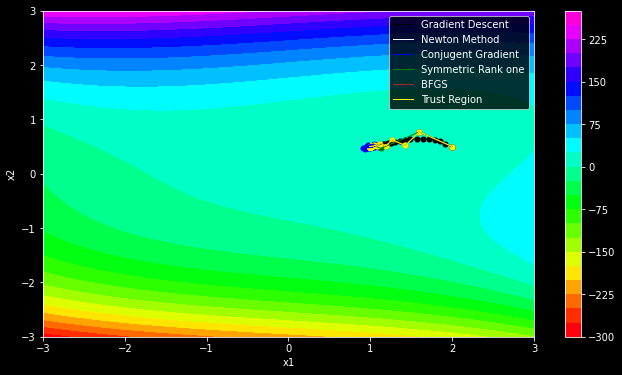

In [510]:
r = 3
plot_2d_function(f, x1_range=[-r, r], x2_range=[-r, r])
add_opt_path(x_gr, color="black",color2="black", label="Gradient Descent")
add_opt_path(x_n, color="white",color2="white", label="Newton Method")
add_opt_path(x_fr, color="blue",color2="blue", label="Conjugent Gradient")
add_opt_path(x_sr1, color="green",color2="green", label="Symmetric Rank one")
add_opt_path(x_bfgs, color="brown",color2="brown", label="BFGS")
add_opt_path(x_bfgs, color="yellow",color2="yellow", label="Trust Region")
plt.legend()

In [511]:
minima_solution_checked_per_geogebra = [1,0.5]
data={"minima":minima_solution_checked_per_geogebra,"gradient descent":x_gr[-1].flatten(),"newton method":x_n[-1].flatten(),"conjugent gradient":x_fr[-1].flatten(),
      "symmetric rank one":x_sr1[-1].flatten(),"bfgs":x_bfgs[-1].flatten(),"trust region":x_trust[-1].flatten()}
df = pd.DataFrame(data, columns=["minima","gradient descent","newton method","conjugent gradient","symmetric rank one","bfgs","trust region"])

heading_properties = [('font-size', '18px')]

cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

df.style.set_table_styles(dfstyle)

,minima,gradient descent,newton method,conjugent gradient,symmetric rank one,bfgs,trust region
0,1.000000,1.018790,1.079690,1.000017,1.000000,1.000004,1.000000
1,0.500000,0.505664,0.519761,0.499819,0.500000,0.500002,0.500000


# 8) Polynomial 2 Variables sine
---

$$
f(x) = sin(x) sin(y)
$$

In [512]:
def f(x):
    return np.sin(x[0]) * np.sin(x[1])

def grad(x):
    return np.array([np.cos(x[0])*np.sin(x[1]), np.sin(x[0])*np.cos(x[1])])

def hess(x):
    return np.array([[-np.sin(x[0])*np.sin(x[1]), np.cos(x[0])*np.cos(x[1])], 
                       [np.cos(x[0])*np.cos(x[1]), np.sin(x[0])*-np.sin(x[1])]])

In [513]:
x_start = np.array([1, -1])

In [514]:
x_gr = gradient_descent(f, grad, x_start.reshape(-1,1))

In [515]:
x_n = newton_method(x_start, f, grad, hess, tol=0.4)

In [516]:
x_fr = fletcher_reeves(f=f, x=x_start, x_true=None, tol=1e-4, stop=1e+2)

In [517]:
x_sr1 = sr1(f, grad, x_start, linesearch=True, alpha=0.1, n_iters=100)

In [518]:
x_bfgs = bfgs(f, grad, x_start, line_search=True, alpha=0.1, n_iters=100)

In [519]:
x_trust = trust_region_dogleg(f, grad, hess, x_start)

In [520]:
minima_solution_checked_per_geogebra = [np.pi/2,-np.pi/2]
data={"minima":minima_solution_checked_per_geogebra,"gradient descent":x_gr[-1].flatten(),"newton method":x_n[-1].flatten(),"conjugent gradient":x_fr[-1].flatten(),
      "symmetric rank one":x_sr1[-1].flatten(),"bfgs":x_bfgs[-1].flatten(),"trust region":x_trust[-1].flatten()}
df = pd.DataFrame(data, columns=["minima","gradient descent","newton method","conjugent gradient","symmetric rank one","bfgs","trust region"])

heading_properties = [('font-size', '18px')]

cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

df.style.set_table_styles(dfstyle)

,minima,gradient descent,newton method,conjugent gradient,symmetric rank one,bfgs,trust region
0,1.570796,1.507206,1.315778,1.570744,1.570796,1.570796,1.570796
1,-1.570796,-1.507206,-1.315778,-1.570744,-1.570796,-1.570796,-1.570796


# 9) Polynomial 2 Variables order 4
---

$$
f(x) = x^4 + y^4
$$

In [521]:
def f(x):
    return x[0]**4 + x[1]**4

def grad(x):
    return np.array([4*x[0]**3, 4*x[1]**3])

def hess(x):
    return np.array([[12*x[0]**2, 0],[0, 12*x[1]**2]])

In [522]:
x_start = np.array([1, 2])

In [523]:
x_gr = gradient_descent(f, grad, x_start.reshape(-1,1), tol=1e-3)

In [524]:
x_n = newton_method(x_start, f, grad, hess, tol=1e-4)

In [525]:
x_fr = fletcher_reeves(f=f, x=x_start, x_true=None, tol=1e-1, stop=1e+2)

In [526]:
x_sr1 = sr1(f, grad, x_start, linesearch=True, alpha=0.1, n_iters=100)

In [527]:
x_bfgs = bfgs(f, grad, x_start, line_search=True, alpha=0.1, n_iters=100)

In [528]:
x_trust = trust_region_dogleg(f, grad, hess, x_start)

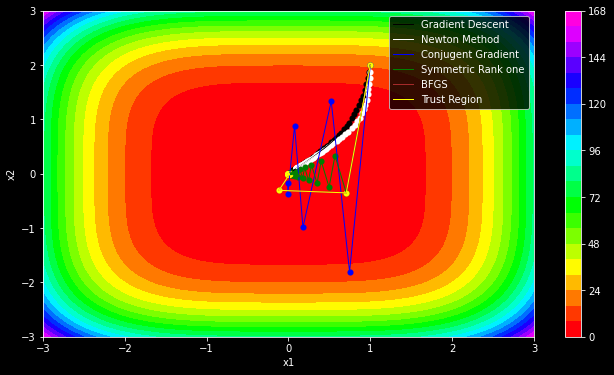

In [529]:
r = 3
plot_2d_function(f, x1_range=[-r, r], x2_range=[-r, r])
add_opt_path(x_gr, color="black",color2="black", label="Gradient Descent")
add_opt_path(x_n, color="white",color2="white", label="Newton Method")
add_opt_path(x_fr, color="blue",color2="blue", label="Conjugent Gradient")
add_opt_path(x_sr1, color="green",color2="green", label="Symmetric Rank one")
add_opt_path(x_bfgs, color="brown",color2="brown", label="BFGS")
add_opt_path(x_bfgs, color="yellow",color2="yellow", label="Trust Region")
plt.legend()

In [530]:
minima_solution_checked_per_geogebra = [0,0]
data={"minima":minima_solution_checked_per_geogebra,"gradient descent":x_gr[-1].flatten(),"newton method":x_n[-1].flatten(),"conjugent gradient":x_fr[-1].flatten(),
      "symmetric rank one":x_sr1[-1].flatten(),"bfgs":x_bfgs[-1].flatten(),"trust region":x_trust[-1].flatten()}
df = pd.DataFrame(data, columns=["minima","gradient descent","newton method","conjugent gradient","symmetric rank one","bfgs","trust region"])

heading_properties = [('font-size', '18px')]

cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

df.style.set_table_styles(dfstyle)

,minima,gradient descent,newton method,conjugent gradient,symmetric rank one,bfgs,trust region
0,0,0.055732,0.092920,-0.008587,0.000000,0.000002,0.007707
1,0,0.055769,0.092921,-0.169670,0.000000,-0.000002,0.015415


# 10) Polynomial 2 Variables order 6
---

$$
f(x) = x_1^2 + x_2^6 + x_1 x_2 
$$

In [531]:

def f(x):
    x1 = x[0]
    x2 = x[1]
    val = x1**2 + x2**6 + x1*x2
    return val

def grad(x):
    x1 = x[0]
    x2 = x[1]
    val = np.array([2 * x1 + x2, 
                    6 * x2**5 + x1])
    return val

def hess(x):
    x1 = x[0]
    x2 = x[1]
    val = np.array([[2, 1], [1, 30 * x2**4]])
    return val

In [532]:
x_start = np.array([0.5, -1])

In [533]:
x_gr = gradient_descent(f, grad, x_start.reshape(-1,1), tol=1e-4)

In [534]:
x_n = newton_method(x_start, f, grad, hess)

In [535]:
x_fr = fletcher_reeves(f=f, x=x_start, x_true=None, tol=1e-4, stop=1e+2)

In [536]:
x_sr1 = sr1(f, grad, x_start, linesearch=True, alpha=0.1, n_iters=100)

In [537]:
x_bfgs = bfgs(f, grad, x_start, line_search=True, alpha=0.1, n_iters=100)

In [538]:
x_trust = trust_region_dogleg(f, grad, hess, x_start)

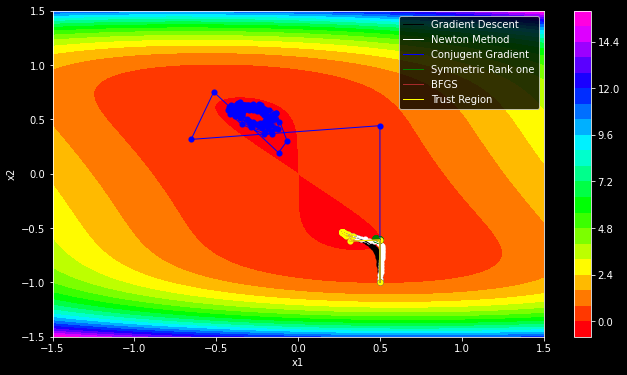

In [539]:
r = 1.5
plot_2d_function(f, x1_range=[-r, r], x2_range=[-r, r])
add_opt_path(x_gr, color="black",color2="black", label="Gradient Descent")
add_opt_path(x_n, color="white",color2="white", label="Newton Method")
add_opt_path(x_fr, color="blue",color2="blue", label="Conjugent Gradient")
add_opt_path(x_sr1, color="green",color2="green", label="Symmetric Rank one")
add_opt_path(x_bfgs, color="brown",color2="brown", label="BFGS")
add_opt_path(x_bfgs, color="yellow",color2="yellow", label="Trust Region")
plt.legend()

In [540]:
minima_solution_checked_per_geogebra = [0.26,0.59]
data={"minima":minima_solution_checked_per_geogebra,"gradient descent":x_gr[-1].flatten(),"newton method":x_n[-1].flatten(),"conjugent gradient":x_fr[-1].flatten(),
      "symmetric rank one":x_sr1[-1].flatten(),"bfgs":x_bfgs[-1].flatten(),"trust region":x_trust[-1].flatten()}
df = pd.DataFrame(data, columns=["minima","gradient descent","newton method","conjugent gradient","symmetric rank one","bfgs","trust region"])

heading_properties = [('font-size', '18px')]

cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

df.style.set_table_styles(dfstyle)

,minima,gradient descent,newton method,conjugent gradient,symmetric rank one,bfgs,trust region
0,0.260000,0.268701,0.268699,-0.301629,0.472226,0.268643,0.268642
1,0.590000,-0.537330,-0.537329,0.590608,-0.601396,-0.537285,-0.537285


## Obeservation:
+ Conjugent Gradient managed to find an other minima